### This notebook generate the line benefits from the operational cost

In [136]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [137]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [138]:
#%% Setting up the path a cases
DirName  = os.getcwd()

CSV_name =  'OC_fy_1'
# CSV_name =  'OC_fy_2'
# CSV_name =  'OC_fy_3'
# CSV_name =  'OC_fy_4'

CaseName_Base     = '3-bus'
CaseName_ByStages = CaseName_Base + '_ByStages_' + CSV_name

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [139]:
df_1 = pd.read_csv(_path_0+'/3.Out/Estimations/'+'Estimated_'+CSV_name+'.csv', index_col=0)

In [140]:
# Assuming your DataFrame is named df
# Calculate the difference for each column
diff_df_1 = df_1.drop(columns=["Network_Existing_Generation_Full"]).subtract(df_1["Network_Existing_Generation_Full"], axis=0)

In [141]:

#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [142]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_2_cac1,Network_Line_In_Node_1_Node_2_cac2,Network_Line_In_Node_1_Node_2_cac3,Network_Line_In_Node_1_Node_3_cac1,Network_Line_In_Node_1_Node_3_cac2,Network_Line_In_Node_1_Node_3_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3
0,0.000297,0.000165,-0.000103,0.001142,0.002000,0.002421,-0.000223,-0.000440,-0.000425
1,0.000029,0.000222,0.000065,0.000758,0.001627,0.002026,-0.000301,-0.000977,-0.000955
2,-0.000047,0.000168,0.000393,0.000583,0.001544,0.001886,-0.000509,-0.001101,-0.001233
3,-0.000037,-0.000092,0.000044,0.000234,0.001373,0.001650,-0.000936,-0.001119,-0.001487
4,-0.000199,-0.000775,-0.000735,-0.000258,0.000868,0.001104,-0.001100,-0.001795,-0.001613


In [143]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [144]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_2_cac1,Network_Line_In_Node_1_Node_2_cac2,Network_Line_In_Node_1_Node_2_cac3,Network_Line_In_Node_1_Node_3_cac1,Network_Line_In_Node_1_Node_3_cac2,Network_Line_In_Node_1_Node_3_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3
LoadLevel,,,,,,,,,
01-01 00:00:00+01:00,0.000297,0.000165,-0.000103,0.001142,0.002000,0.002421,-0.000223,-0.000440,-0.000425
01-01 01:00:00+01:00,0.000029,0.000222,0.000065,0.000758,0.001627,0.002026,-0.000301,-0.000977,-0.000955
01-01 02:00:00+01:00,-0.000047,0.000168,0.000393,0.000583,0.001544,0.001886,-0.000509,-0.001101,-0.001233
01-01 03:00:00+01:00,-0.000037,-0.000092,0.000044,0.000234,0.001373,0.001650,-0.000936,-0.001119,-0.001487
01-01 04:00:00+01:00,-0.000199,-0.000775,-0.000735,-0.000258,0.000868,0.001104,-0.001100,-0.001795,-0.001613


In [145]:
ddf_1 = diff_df_1.stack()

In [146]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [147]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [148]:
ddf_1.head()

Value
LoadLevel            Execution                                   
01-01 00:00:00+01:00 Network_Line_In_Node_1_Node_2_cac1  0.000297
                     Network_Line_In_Node_1_Node_2_cac2  0.000165
                     Network_Line_In_Node_1_Node_2_cac3 -0.000103
                     Network_Line_In_Node_1_Node_3_cac1  0.001142
                     Network_Line_In_Node_1_Node_3_cac2  0.002000

In [149]:
ddf_1 = ddf_1.reset_index()

In [150]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [151]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [152]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
78619,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.001059,1900-12-30 23:00:00
78620,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac3,0.002249,1900-12-30 23:00:00
78621,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,0.000017,1900-12-30 23:00:00
78622,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,0.000049,1900-12-30 23:00:00
78623,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac3,0.000154,1900-12-30 23:00:00


#### Getting day of year and month

In [153]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [154]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac1,0.000297,1900-01-01,0,1,1,1
1,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac2,0.000165,1900-01-01,0,1,1,1
2,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac3,-0.000103,1900-01-01,0,1,1,1
3,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_3_cac1,0.001142,1900-01-01,0,1,1,1
4,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.002000,1900-01-01,0,1,1,1


#### Generation new ID considering each line, and hour

In [155]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [156]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
78619,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.001059,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_1_Node_3_cac2_23
78620,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac3,0.002249,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_1_Node_3_cac3_23
78621,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,0.000017,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac1_23
78622,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,0.000049,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac2_23
78623,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac3,0.000154,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac3_23


In [157]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [158]:
table.tail()

Variable   Network_Line_In_Node_1_Node_2_cac1_0  \
Month Day                                         
12    360                         -3.481710e-04   
      361                         -1.937990e-04   
      362                         -4.000000e-09   
      363                          1.067620e-04   
      364                         -4.147700e-05   

Variable   Network_Line_In_Node_1_Node_2_cac1_1  \
Month Day                                         
12    360                         -2.345330e-04   
      361                         -9.234700e-05   
      362                          9.000000e-09   
      363                          1.100000e-08   
      364                         -1.063000e-05   

Variable   Network_Line_In_Node_1_Node_2_cac1_10  \
Month Day                                          
12    360                              -0.000437   
      361                               0.000875   
      362                               0.000017   
      363                               0.000467   
      364                              -0.000422   

Variable   Network_Line_In_Node_1_Node_2_cac1_11  \
Month Day                                          
12    360                           2.637410e-04   
      361                          -3.297700e-05   
      362                          -1.100000e-08   
      363                          -8.180720e-04   
      364                          -2.252170e-04   

Variable   Network_Line_In_Node_1_Node_2_cac1_12  \
Month Day                                          
12    360                          -6.174890e-04   
      361                          -6.431500e-05   
      362                          -2.100000e-08   
      363                          -4.833070e-04   
      364                          -4.948300e-05   

Variable   Network_Line_In_Node_1_Node_2_cac1_13  \
Month Day                                          
12    360                          -9.055960e-04   
      361                          -5.365000e-05   
      362                          -2.100000e-08   
      363                          -5.383450e-04   
      364                          -2.905000e-06   

Variable   Network_Line_In_Node_1_Node_2_cac1_14  \
Month Day                                          
12    360                          -4.045700e-04   
      361                          -4.226000e-05   
      362                          -2.200000e-08   
      363                          -3.683300e-04   
      364                          -6.000000e-09   

Variable   Network_Line_In_Node_1_Node_2_cac1_15  \
Month Day                                          
12    360                           1.022060e-04   
      361                          -2.512000e-05   
      362                          -1.600000e-08   
      363                          -3.297630e-04   
      364                          -1.800000e-08   

Variable   Network_Line_In_Node_1_Node_2_cac1_16  \
Month Day                                          
12    360                               0.000050   
      361                               0.000148   
      362                              -0.000076   
      363                              -0.000690   
      364                               0.000104   

Variable   Network_Line_In_Node_1_Node_2_cac1_17  ...  \
Month Day                                         ...   
12    360                               0.000178  ...   
      361                              -0.000175  ...   
      362                              -0.000167  ...   
      363                              -0.000232  ...   
      364                               0.000442  ...   

Variable   Network_Line_In_Node_2_Node_3_cac3_21  \
Month Day                                          
12    360                              -0.001865   
      361                              -0.000042   
      362                               0.000050   
      363                              -0.001194   
      364        

In [159]:
table = table.reset_index()

In [160]:
table = table.set_index(['Day'])

In [161]:
table.tail()

Variable,Month,Network_Line_In_Node_1_Node_2_cac1_0,Network_Line_In_Node_1_Node_2_cac1_1,Network_Line_In_Node_1_Node_2_cac1_10,Network_Line_In_Node_1_Node_2_cac1_11,Network_Line_In_Node_1_Node_2_cac1_12,Network_Line_In_Node_1_Node_2_cac1_13,Network_Line_In_Node_1_Node_2_cac1_14,Network_Line_In_Node_1_Node_2_cac1_15,Network_Line_In_Node_1_Node_2_cac1_16,...,Network_Line_In_Node_2_Node_3_cac3_21,Network_Line_In_Node_2_Node_3_cac3_22,Network_Line_In_Node_2_Node_3_cac3_23,Network_Line_In_Node_2_Node_3_cac3_3,Network_Line_In_Node_2_Node_3_cac3_4,Network_Line_In_Node_2_Node_3_cac3_5,Network_Line_In_Node_2_Node_3_cac3_6,Network_Line_In_Node_2_Node_3_cac3_7,Network_Line_In_Node_2_Node_3_cac3_8,Network_Line_In_Node_2_Node_3_cac3_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,-3.481710e-04,-2.345330e-04,-0.000437,2.637410e-04,-6.174890e-04,-9.055960e-04,-4.045700e-04,1.022060e-04,0.000050,...,-0.001865,-0.001284,-1.476923e-03,-1.729656e-03,-2.055079e-03,-0.002487,-0.002138,-0.001948,-0.001828,-0.001722
361,12,-1.937990e-04,-9.234700e-05,0.000875,-3.297700e-05,-6.431500e-05,-5.365000e-05,-4.226000e-05,-2.512000e-05,0.000148,...,-0.000042,0.000036,6.400000e-08,-1.785005e-03,-1.790246e-03,-0.002133,-0.002248,-0.002117,-0.001863,-0.001330
362,12,-4.000000e-09,9.000000e-09,0.000017,-1.100000e-08,-2.100000e-08,-2.100000e-08,-2.200000e-08,-1.600000e-08,-0.000076,...,0.000050,0.000059,5.156200e-05,3.600000e-08,1.900000e-08,-0.000070,-0.000269,-0.001829,-0.001648,-0.000907
363,12,1.067620e-04,1.100000e-08,0.000467,-8.180720e-04,-4.833070e-04,-5.383450e-04,-3.683300e-04,-3.297630e-04,-0.000690,...,-0.001194,-0.001001,-8.777620e-04,3.468930e-04,-1.795396e-03,-0.001877,-0.002055,-0.002004,-0.001596,-0.001223
364,12,-4.147700e-05,-1.063000e-05,-0.000422,-2.252170e-04,-4.948300e-05,-2.905000e-06,-6.000000e-09,-1.800000e-08,0.000104,...,0.000094,0.000058,1.536480e-04,-1.818737e-03,-1.646588e-03,-0.002136,-0.002238,-0.002076,-0.001508,-0.000860


#### Split data table into data X and class labels y

In [162]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [163]:
print(X)
print(y)

[[ 2.965200e-04  2.934400e-05 -3.827460e-04 ... -1.413623e-03
  -1.338998e-03 -1.347378e-03]
 [ 3.839590e-04  1.859910e-04 -2.647000e-06 ... -1.567086e-03
  -1.705311e-03 -1.994040e-03]
 [ 2.715200e-04 -3.334800e-05 -1.149630e-04 ... -1.432899e-03
  -1.309809e-03 -1.585992e-03]
 ...
 [-4.000000e-09  9.000000e-09  1.690400e-05 ... -1.828809e-03
  -1.648052e-03 -9.072440e-04]
 [ 1.067620e-04  1.100000e-08  4.667100e-04 ... -2.004018e-03
  -1.595732e-03 -1.222878e-03]
 [-4.147700e-05 -1.063000e-05 -4.215800e-04 ... -2.075669e-03
  -1.508132e-03 -8.602140e-04]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  

## PCA step by step

#### Standardizing of the data

In [164]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [165]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.00048696 -0.07597488  0.03006682 ... -0.00730465 -0.0062211
   0.00041653]
 [-0.00910449 -0.05919258  0.07071393 ...  0.00382937  0.05829937
  -0.02267148]
 [-0.0091848   0.01933572 -0.11349033 ... -0.02830493 -0.00812496
   0.00915121]
 ...
 [ 0.08651092  0.06767478  0.03072221 ...  0.0328276   0.10459122
  -0.03127657]
 [ 0.0950227   0.06509557  0.02365691 ... -0.09533521 -0.12970828
   0.0026694 ]
 [ 0.10313541  0.03882931  0.01739542 ...  0.02669252  0.12975612
   0.06142536]]

Eigenvalues 
[6.93103411e+01 1.81677970e+01 1.44580125e+01 1.13878054e+01
 1.07495387e+01 6.00846634e+00 5.70616569e+00 5.23619590e+00
 4.67192122e+00 4.44713309e+00 3.75180026e+00 3.57281255e+00
 3.32288600e+00 2.83681330e+00 2.58054320e+00 2.51660878e+00
 2.22643015e+00 2.08607146e+00 1.96394510e+00 1.78285494e+00
 1.73292145e+00 1.64339743e+00 1.54995115e+00 1.50143219e+00
 1.42731441e+00 1.29466273e+00 1.27388385e+00 1.16746485e+00
 1.11678290e+00 1.07734277e+00 1.02665398e+00 9.616102

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [166]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [167]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
69.3103411116994
18.16779697245407
14.458012453605173
11.387805372077395
10.749538657852014
6.008466341022408
5.706165693574448
5.236195901891441
4.671921216851146
4.447133087636217
3.7518002554604917
3.572812553835799
3.322886003354063
2.8368133044867463
2.5805431987657816
2.5166087771059207
2.2264301497637122
2.0860714552131245
1.9639450955229911
1.7828549393890192
1.7329214450814123
1.6433974255879833
1.5499511469758585
1.5014321940713562
1.4273144056326719
1.2946627288525563
1.2738838499499172
1.167464846526918
1.116782898254654
1.077342769830777
1.0266539794740974
0.9616102946796488
0.9446905753848964
0.8974571157492939
0.860665654602805
0.8201291359067705
0.7896259304645654
0.7614824153709675
0.7166926118153132
0.6506229880883898
0.6086473125373255
0.6017906577947502
0.5565661344794625
0.5316563537195134
0.5060017708815808
0.5008549811424485
0.49038132167879095
0.4717786211546901
0.45570124711288834
0.4261724235625721
0.41613956786713796
0.3931380

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [168]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [169]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

31.999966706790378 0
40.38787663378572 1
47.06301211488395 2
52.320660352144955 3
57.28362653651649 4
60.05768189084994 5
62.69216773075573 6
65.1096727068274 7
67.26665709037054 8
69.3198587982612 9
71.05203153525264 10
72.70156724577664 11
74.23571409561578 12
75.545445512904 13
76.73685930659546 14
77.89875514767382 15
78.92667810296003 16
79.88979870003263 17
80.79653464538627 18
81.61966287976536 19
82.41973726489529 20
83.17847920818033 21
83.89407783754571 22
84.5872756988195 23
85.24625403780588 24
85.84398827998827 25
86.43212909898988 26
86.97113721265653 27
87.48674592254974 28
87.9841454766917 29
88.45814246813082 30
88.9021093700548 31
89.33826458839108 32
89.75261253942003 33
90.1499742007713 34
90.52862051275511 35
90.89318376667076 36
91.24475341051954 37
91.57564400129202 38
91.87603083568875 39
92.15703787482572 40
92.43487925758352 41
92.69184088102679 42
92.93730188072178 43
93.1709183881877 44
93.40215866870601 45
93.6285633540049 46
93.84637933828343 47
94.0567725

Then

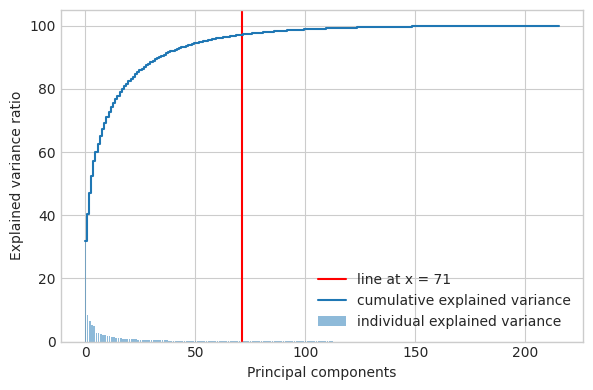

In [170]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [171]:
labels = np.unique(y, axis=0)

In [172]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

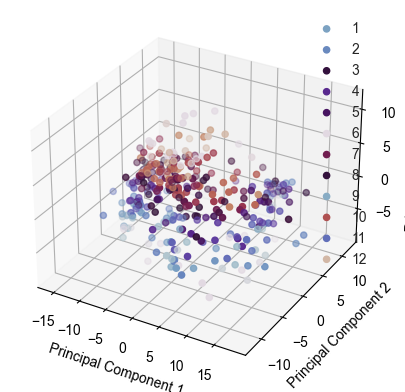

In [173]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

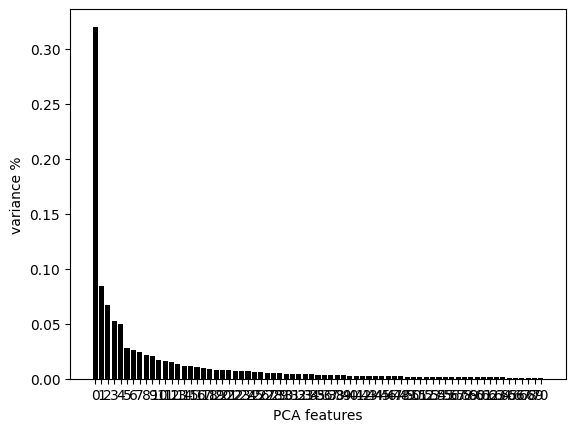

In [174]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [175]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [176]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.190177,-3.242898,-3.110044,7.222926,3.978778,0.355803,-7.116478,0.329873,2.446250,-3.976520,...,-0.124670,-0.520189,1.272278,-0.577397,-0.016323,-0.158785,-0.423689,-0.580844,-0.516171,-0.165859
1,-0.801956,-2.421310,3.566856,1.228321,-4.719248,-0.314530,-1.995396,0.385525,-1.014664,2.128942,...,-0.085344,-0.520898,-0.172030,0.567901,0.045983,0.013208,-0.134111,0.112739,0.621619,-0.186719
2,2.111900,-0.174707,2.873087,5.319830,-2.084978,-3.918125,-2.316516,-3.159127,0.781627,-3.713957,...,0.448604,-0.567768,-0.223532,-0.368962,-0.037640,-0.524912,0.110888,0.315152,0.727272,-0.301145
3,1.213521,-5.010504,-4.970082,4.305326,6.487614,-1.856068,-5.290648,-4.765040,-2.916700,-2.609714,...,0.653284,0.266313,0.590435,1.027364,-0.222280,-0.167518,-0.052272,-1.236728,0.059947,0.351021
4,-5.028181,-1.519750,6.045685,-1.057340,0.156520,0.299296,1.277816,-1.759291,-2.320101,1.809166,...,0.309607,-0.178248,-0.394956,0.470680,-0.032931,0.088072,0.253542,-0.131722,-0.291027,-0.343002


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

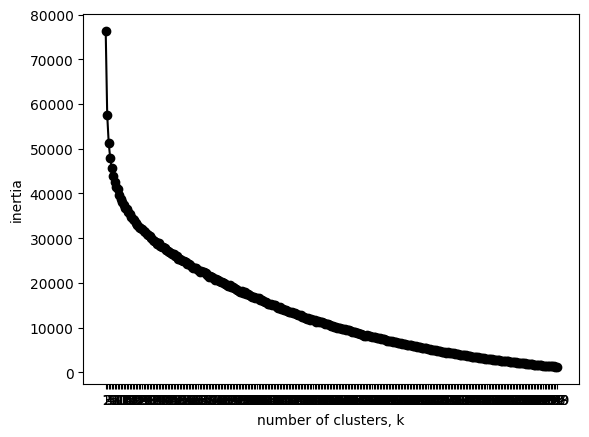

In [177]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [178]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  37


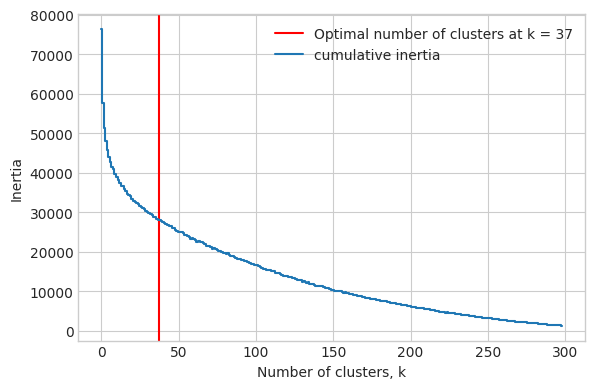

In [179]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [180]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
